<a href="https://colab.research.google.com/github/licciard/lu-phys3466/blob/main/fourier_transform_1_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Fast Fourier Transform Algorithm**

This notebook is dedicated to explain the optimal implementation of Fourier transform in numerical applications. The bottom line is that by exploiting a symmetry in the calculation of the transform, we can substantially reduce the number of calculations performed.

The **Discrete Fourier Transform** (DFT) of an array with $N$ data points can be calculated by: 
$$X[\omega] = \sum_{t=0}^{N-1} x[t] e^{-i \frac{2\pi t \omega}{N}}$$
using the same notations of our lectures, but with a reversed sign of $i$ for the direct FT because this is the standard in computer implementations.

Let's first create a simple **signal**.

In [ ]:
# modules for the notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy 

Here we start with a mono-frequency signal of 8 Hz, and sample it at 128 Hz. This means that while the signal oscillates with 10 cycles per second, we grab 128 data points per second. That gives a total of 16 samples per cycle. The choice of sampling is very important: too few samples won't give you a good idea of the signal. 


**Activity 1.** Play with the numbers of frequency and sampling rate to check this. For example, change the sampling rate to very low values to see that the signal seems to disappear. Then bring it back to 128 before proceeding to the next activity.

In [ ]:
f = 8  # Frequency, in cycles per second
f_s = 128  # Sampling rate = number of measurements per second

t = np.linspace(0, 2, 2 * f_s, endpoint=False)
print("We will need an array with an exact power of 2 entries in the following exercise. Our array has {} entries.".format(len(t)))
x = np.sin(f * 2 * np.pi * t)

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.plot(t, x, '-') # <-- change the option from '-' to '.' to see the actual points used in the plot
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude')
plt.show()

**Activity 2.** Complete the argument of the exponential function in our "naive" implementation of the DFT. Use the expression exactly like the formula above, including the notation (here we call $\omega$ by $w$). Then run the next code block to print whether the implementation matches the result against a DFT implementation from python's module *scipy*.

In [ ]:
def our_DFT(xloc):
    xloc = np.asarray(xloc, dtype=float)
    N = xloc.shape[0]
    w = np.arange(N)
    t = w.reshape((N, 1))
    M = np.exp(-2j * ???) # <-- complete this line
    return np.dot(M, xloc)

In [ ]:
our_X = our_DFT(x)
X = scipy.fft.fft(x)
correct = np.allclose(our_X,X)
print("Does our DFT implementation match scipy's? {}".format(correct))

Does our DFT implementation match scipy's? True


**Activity 3.** Run the code below to compute the running times for our DFT and scipy's implementation. Take note of the times. (Disregard the number of loops.)

In [ ]:
%timeit scipy.fft.fft(x)
%timeit our_DFT(x)

Introducing the **Fast Fourier Transform (FFT)** algorithm. Below is a very nice explanation taken from:
*   https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/
*   https://towardsdatascience.com/fast-fourier-transform-937926e591cb 

Cooley and Tukey showed that it's possible to divide the DFT computation into two smaller parts.  From
the definition of the DFT we have:
$$\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align}$$
[*Note they use the variable names $\omega \leftrightarrow k$ and $t \leftrightarrow n$.*]

We've split the single Discrete Fourier transform into two terms which themselves look very similar to smaller Discrete Fourier Transforms, one on the odd-numbered values, and one on the even-numbered values. So far, however, we haven't saved any computational cycles.  Each term consists of $(N/2)*N$ computations, for a total of $N^2$.

The trick comes in making use of symmetries in each of these terms.  Because the range of $k$ is $0 \le k < N$, while the range of $n$ is $0 \le n < M \equiv N/2$, we see from the symmetry properties above that we need only perform half the computations for each sub-problem.  Our $\mathcal{O}[N^2]$ computation has become $\mathcal{O}[M^2]$, with $M$ half the size of $N$.

[*Recall the big-O notation "$\mathcal{O}$" from the lectures? That means a function that "multiplies" the factor in the argument, i.e. that is proportional to it.*]


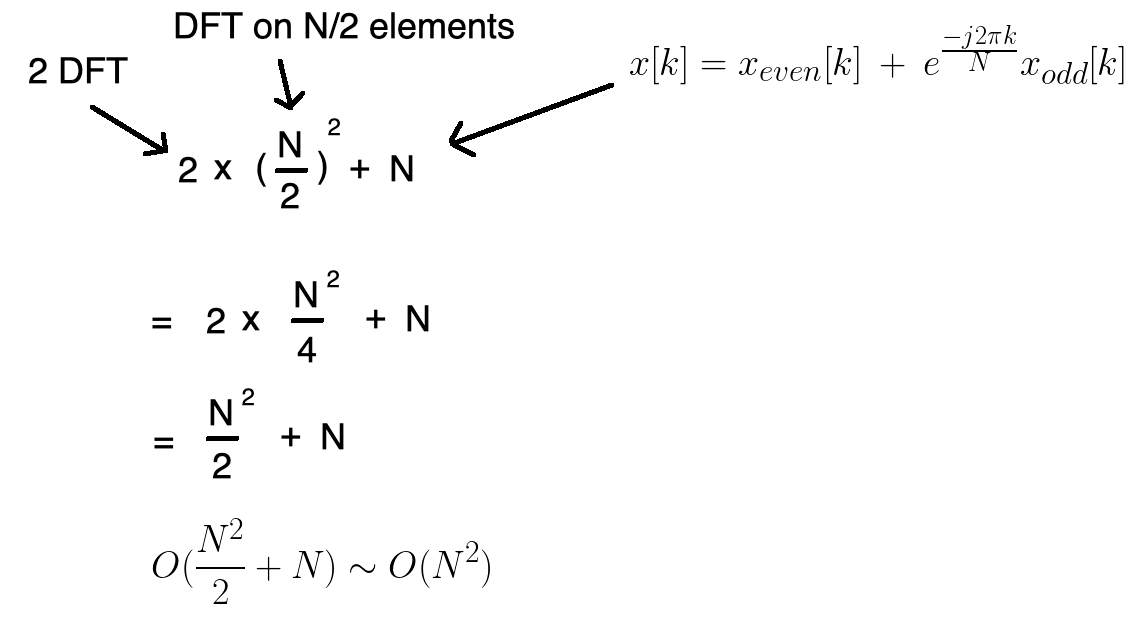

**Activity 4.** Compute the time required to run each of the three FT algorithms: our DFT, our FFT (below) and scipy's. Is our FFT time shorter than our DFT? By what factor? Is it consistent with the explanation above: $\mathcal{O}[N^2] \rightarrow \mathcal{O}[N^2/2]$?

In [ ]:
def our_FFT(xloc):
    xloc = np.asarray(xloc, dtype=float)
    N = xloc.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return our_DFT(xloc)
    else:
        X_even = our_FFT(xloc[::2])
        X_odd = our_FFT(xloc[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])

In [ ]:
%timeit scipy.fft.fft(x)
%timeit our_DFT(x)
%timeit our_FFT(x)

There's no reason to stop there: as long as our smaller Fourier transforms have an even-valued $M$, we can reapply this divide-and-conquer approach, halving the computational cost each time, until our arrays are small enough that the strategy is no longer beneficial.  In the asymptotic limit, this recursive approach scales as $\mathcal{O}[N\log N]$.

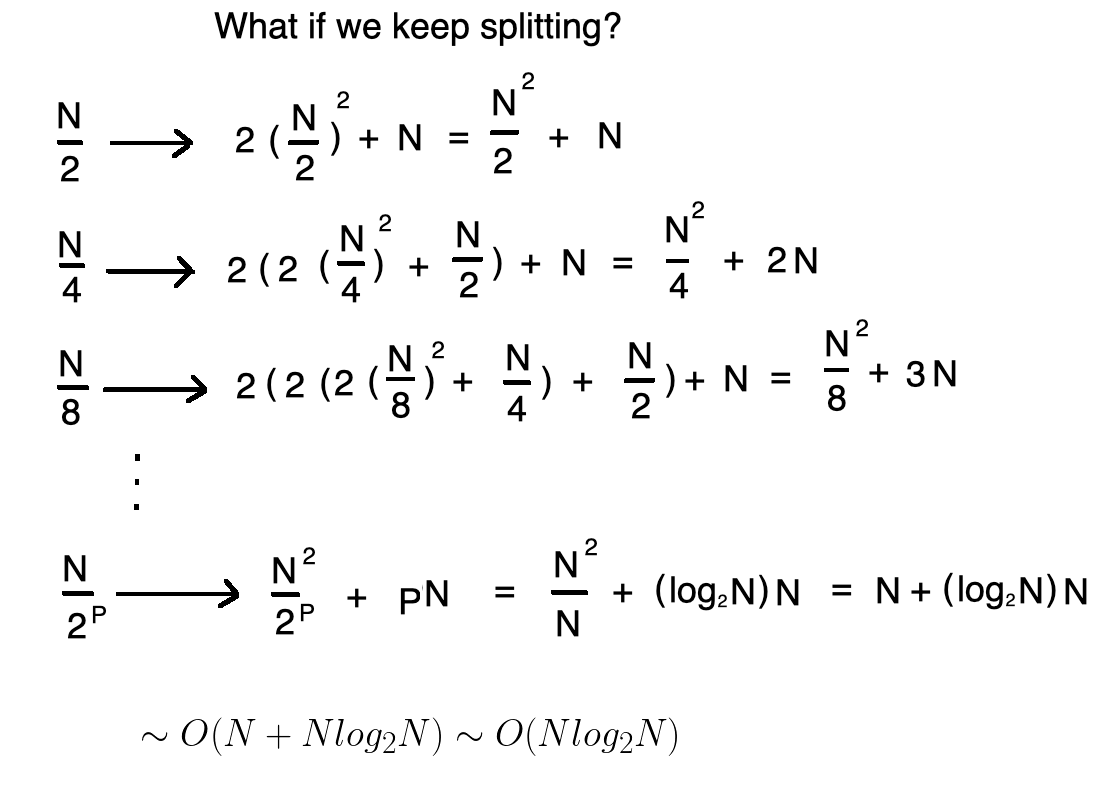

So long as $N$ is a power of 2, the maximum number of times you can split into two equal halves is given by $p = \ln(N)$.

This recursive algorithm can be implemented very quickly in Python, falling-back on our slow DFT code when the size of the sub-problem becomes suitably small.

**Activity 5.** Run the code below to plot the DFT of your signal. Do you understand what is happening? Why do we have two peaks at $\pm 8$ Hz? Vary the definition of your signal for different frequencies and then different samples to see if they make sense for you.

In [ ]:
freqs = scipy.fft.fftfreq(len(x)) * f_s
fig, ax = plt.subplots()
#ax.stem(freqs, np.abs(our_X), use_line_collection=True)
ax.stem(freqs, np.abs(scipy.fft.fft(x)), use_line_collection=True)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 5, f_s / 5)
ax.set_ylim(-5, 150)